In [4]:
import logging

#set the logger level
logging.basicConfig(level='WARNING') 

logger=logging.getLogger(__name__)

logger.setLevel('DEBUG')
ch=logging.StreamHandler()
ch.setLevel(logging.DEBUG)

formatter=logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

ch.setFormatter(formatter)
logger.addHandler(ch) 
logger.propagate=False

In [2]:
import numpy as np
import time


# 高维量子态对低维随机幺正矩阵的表现如何？

In [5]:
Sx = np.array([[0,1],[1,0]])
Sy = np.array([[0,-1.j],[1.j,0]])
Sz = np.array([[1,0],[0,-1]])
Id = np.array([[1,0],[0,1]])
CNOT = np.array([[1,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0]])





def normalize(state):
    return state/np.sqrt(np.vdot(state,state))
def vector_reshape(state,N):
    '''将列矢量的向量转换为对每个Qubit的矢量
    '''
    shape = []
    for i in range(N):
        shape.append(2)
    return np.reshape(state,shape)


def rx(theta):
    return np.array([[np.cos(theta/2),-1.j*np.sin(theta/2)],\
                     [-1.j*np.sin(theta/2),np.cos(theta/2)]])   

def ry(theta):
    return np.array([[np.cos(theta/2),-np.sin(theta/2)],\
                     [np.sin(theta/2),np.cos(theta/2)]]) 

def rz(theta):
    return np.array([[np.cos(theta/2)-1.j*np.sin(theta/2),0],\
                     [0,np.cos(theta/2)+1.j*np.sin(theta/2)]]) 



def index_site_to_tuple_list(list_tuples):
    '''Input eg: [('00',[1,2]),('1111',[0,3,4,5])]
    
    Output eg: (1, 1, 1, 0, 0, 1)
    '''
    binary_list = []
    for N_ind in range(N-1,-1,-1):
        for tuples in list_tuples:
            if N_ind in tuples[1]:
                site = tuples[1].index(N_ind)
                binary = int(tuples[0][site])
                break
        binary_list.append(binary)
    return tuple(binary_list)


#def tuple_to_oct_number(bi_tuple):
#    '''Input eg:(1, 0, 1, 1)
#    Output eg:11
#    '''
#    bi_list = list(bi_tuple)
#    bi_str = ''
#    for entry in bi_list:
#        bi_str.append(str(entry))
#    return int(bi_str,2)

    

def gate(unitary,site,vector):
    '''将unitary gate施加在哪个site 的Qubit 的vector上
    '''
    
    
    size = int(np.log2(len(unitary))) #unitary 是 size*size 的矩阵
    res_size = N-size
    
    if type(site) == int:
        site = [site]
    else:
        site = list(site)
        
    res_site = []
    for N_ind in range(N):
        if not (N_ind in site):
            res_site.append(N_ind)
    
    #主要作用的qubit binary 集合
    binary_list = []
    #剩余的qubit binary 集合
    binary_list_res = []
    
    for i in range(2**size):
        binary_list.append(bin(i)[2:].zfill(size))
        

    shape = []
    for i in range(N):
        shape.append(2)

    result_vector = np.zeros(shape)+1.j*np.zeros(shape)
        
    if res_size > 0.1:
        for i in range(2**res_size):
            binary_list_res.append(bin(i)[2:].zfill(res_size))



        for res_ind in range(2**res_size):
            for ind in range(2**size):
                for ind_prod in range(2**size):
                    result_vector[index_site_to_tuple_list([(binary_list[ind],site),(binary_list_res[res_ind],res_site)])] +=  \
                    unitary[ind,ind_prod]* \
                    vector[index_site_to_tuple_list([(binary_list[ind_prod],site),(binary_list_res[res_ind],res_site)])]
    
    #针对门qubit数与线路qubit数相等时（即res_size==0）的计算
    else:
        for ind in range(2**size):
            for ind_prod in range(2**size):
                result_vector[index_site_to_tuple_list([(binary_list[ind],site)])] +=  \
                unitary[ind,ind_prod]* \
                vector[index_site_to_tuple_list([(binary_list[ind_prod],site)])]



    
    return result_vector
    
    

N = 10




r= np.random.random(2**N)


r = normalize(r)

print_vector = False

r = vector_reshape(r,N)

if print_vector ==True:
    print("\nOriginal vector:\n",r)

    time_start = time.time()
    print("0->1 CNOT:\n",gate(CNOT,(1,0),r)) #0控1 CNOT
    logger.debug("time of CNOT %.3f s",time.time()-time_start)

    print("1->0 CNOT:\n",gate(CNOT,(0,1),r)) #1控0 CNOT

    time_start = time.time()
    print("0-PauliX:\n",gate(Sx,0,r))
    logger.debug("time of PauliX %.3f s",time.time()-time_start)

    print("1-PauliX:\n",gate(Sx,1,r))
else:
    time_start = time.time()
    result_cnot = gate(CNOT,(1,0),r) #0控1 CNOT
    logger.debug("time of CNOT %.3f s",time.time()-time_start)
    
    
    time_start = time.time()
    result_x = gate(Sx,0,r)
    logger.debug("time of PauliX %.3f s",time.time()-time_start)

2021-09-01 00:32:16,963 - __main__ - DEBUG - time of CNOT 0.096 s
2021-09-01 00:32:17,013 - __main__ - DEBUG - time of PauliX 0.044 s


# Single qubit Time  benchmarking

In [120]:
import matplotlib.pyplot as plt

N_list = [15,16,17,18,19]
CNOT_time_list = []
PauliX_time_list = []
for N in N_list:
    r= np.random.random(2**N)


    r = normalize(r)

    print_vector = False

    r = vector_reshape(r,N)
    
    
    time_start = time.time()
    rc = gate(CNOT,(1,0),r) #0控1 CNOT
    CNOT_time_list.append(time.time()-time_start)
    
    
    time_start = time.time()
    rx = gate(Sx,0,r)
    PauliX_time_list.append(time.time()-time_start)

    logger.debug("%d qubits finished",N)
    

2021-08-29 23:36:49,785 - __main__ - DEBUG - 15 qubits finished
2021-08-29 23:37:02,334 - __main__ - DEBUG - 16 qubits finished
2021-08-29 23:37:30,485 - __main__ - DEBUG - 17 qubits finished
2021-08-29 23:38:27,940 - __main__ - DEBUG - 18 qubits finished
2021-08-29 23:40:30,751 - __main__ - DEBUG - 19 qubits finished


In [129]:
print(CNOT_time_list[4])
print(PauliX_time_list[4])

80.24458074569702
42.556708097457886


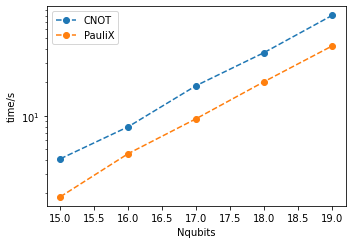

In [124]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize = (5,3.5),tight_layout = True)


                      
ax.plot(N_list ,CNOT_time_list,'o--',label='CNOT')
ax.plot(N_list ,PauliX_time_list,'o--',label='PauliX')

ax.set_yscale('log')

ax.set_xlabel('Nqubits')
ax.set_ylabel('time/s')    
ax.legend(loc='best')

plt.show()

# data from c++

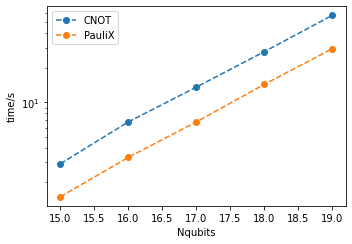

In [1]:
import matplotlib.pyplot as plt

N_list = [15,16,17,18,19]
PauliX_time_list = [1.49424, 3.3023, 6.72898, 14.3376, 29.3292]
CNOT_time_list = [2.90472, 6.7392, 13.5737, 27.6713, 57.4897]
fig,ax = plt.subplots(figsize = (5,3.5),tight_layout = True)


                      
ax.plot(N_list ,CNOT_time_list,'o--',label='CNOT')
ax.plot(N_list ,PauliX_time_list,'o--',label='PauliX')

ax.set_yscale('log')

ax.set_xlabel('Nqubits')
ax.set_ylabel('time/s')    
ax.legend(loc='best')

plt.show()

In [6]:
from math import pi

N = 2
r = np.array([1,2,3,4])
r = normalize(r)
r = vector_reshape(r,N)

gate1 = rx(pi/3)
gate(gate1,0,r)

array([[0.15811388-0.18257419j, 0.31622777-0.09128709j],
       [0.47434165-0.36514837j, 0.63245553-0.27386128j]])

In [11]:
a = 0.316228-1.j*0.0912871
b = 0.158114-1.j*0.182574
b*np.conjugate(b)

(0.058333302472+0j)

In [9]:
np.s_[1:5:2,::3]

(slice(1, 5, 2), slice(None, None, 3))

In [143]:
a = [1]
np.arange(4).reshape(2,2)[1,1]

3

In [138]:
np.arange(4).reshape(2,2)

array([[0, 1],
       [2, 3]])

In [46]:
N=6
def index_site_to_tuple_list(list_tuples):
    '''Input eg: [('00',[1,2]),('1111',[0,3,4,5])]
    
    Output eg: (1, 1, 1, 0, 0, 1)
    '''
    binary_list = []
    for N_ind in range(N-1,-1,-1):
        for tuples in list_tuples:
            if N_ind in tuples[1]:
                site = tuples[1].index(N_ind)
                binary = int(tuples[0][site])
                break
        binary_list.append(binary)
    return tuple(binary_list)
                
    
index_site_to_tuple_list([('00',[1,2]),('1111',[0,3,4,5])])

(1, 1, 1, 0, 0, 1)

In [51]:
site=(0,1)
list(site).index(1)

1

In [55]:
a = N-len([1])
type(a)==int

True

In [57]:
type(2**3)

int

In [83]:
int('1011',2)

11

In [84]:
for 
list((1, 1, 1, 0, 0, 1))

[1, 1, 1, 0, 0, 1]

In [86]:
binary_list = []
for i in range(2**2):
    binary_list.append(bin(i)[2:].zfill(2))
print(binary_list)

['00', '01', '10', '11']


In [ ]:
np.arange(2*10*4).reshape(2,10,4)